Since 'df.append' is depricated in pandas 2, BE-Hive code fails, so set up a virtual enviroment an earler with python3.7. I installed the following: jupyter, numpy, pandas, Bio torch, scikit-learn, and torchvision. Full list of installed packages/dependencies are here: 

In [13]:
pip list

Package                  Version
------------------------ -----------
anyio                    3.7.1
argon2-cffi              23.1.0
argon2-cffi-bindings     21.2.0
attrs                    23.2.0
backcall                 0.2.0
beautifulsoup4           4.12.3
bio                      1.6.2
biopython                1.81
biothings-client         0.3.1
bleach                   6.0.0
certifi                  2024.6.2
cffi                     1.15.1
charset-normalizer       3.3.2
comm                     0.1.4
debugpy                  1.7.0
decorator                5.1.1
defusedxml               0.7.1
entrypoints              0.4
exceptiongroup           1.2.1
fastjsonschema           2.19.1
gprofiler-official       1.0.0
idna                     3.7
importlib-metadata       6.7.0
importlib-resources      5.12.0
ipykernel                6.16.2
ipython                  7.34.0
ipython-genutils         0.2.0
ipywidgets               8.1.3
jedi                     0.19.1
Jinja2                 

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import itertools 
from collections import defaultdict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# location of BE-HIVE Model stored

In [5]:
#download and store BE-HIVE model
#https://github.com/maxwshen/be_predict_efficiency
location_of_BEHIVE_model = #location of BE-HIVE MOdel

In [6]:
import sys
sys.path.append(location_of_BEHIVE_model)
from be_predict_efficiency import predict as be_efficiency_model
be_efficiency_model.init_model(base_editor = 'ABE8', celltype = 'mES')
from be_predict_bystander import predict as bystander_model
bystander_model.init_model(base_editor = 'ABE8', celltype = 'mES')

Model successfully initialized. Settings:
	celltype: mES
	base_editor: ABE8
Model successfully initialized. Settings:
	celltype: mES
	base_editor: ABE8


In [10]:
os.chdir('/home/ivan/Desktop/ABE v DMS Code Data/Figure 3 ABE vs DMS/BE-HIVE Model')

In [11]:
def RevComplment(s): #Case-senstive reverse complmnentarty conversion
    comp = []
    for i in s[::-1]:
        if i == 'a':
            comp.append('t')
        if i == 'A':
            comp.append('T')
        if i == 't':
            comp.append('a')
        if i == 'T':
            comp.append('A')
        if i == 'c':
            comp.append('g')
        if i == 'C':
            comp.append('G')
        if i == 'g':
            comp.append('c')
        if i == 'G':
            comp.append('C')
    return ''.join(comp)

In [12]:
codon_dict = {}
with open("CodonTable.txt") as File:
    for line in File:
        line = line.split()
        codon_dict[line[1]] = line[3]

In [13]:
#load sgRNA mutation predictions
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)]
sgRNA_pred_ABE['mut'] = sgRNA_pred_ABE['Ref_AA'] + sgRNA_pred_ABE['ABL1_AA'].astype(str) + sgRNA_pred_ABE['Alt_AA']

#DESeq2 statistics for ABE NEW Screen
ABE_DESeq2 = pd.read_csv('ABE_D0_DF240603.csv')[['sgName', 'ABE_growthrate', 'pvalue', 'padj']]
ABE_DESeq2.columns = ['sgName', 'ABE_growthrate', 'ABE_pvalue', 'ABE_padj']
#DESeq2 statistics for DMS Screen
DMS_DESeq2 = pd.read_csv('DMS_DF240603.csv')[['mut', 'growth_rate', 'pvalue', 'padj']]
DMS_DESeq2= DMS_DESeq2.loc[DMS_DESeq2['mut'].str[1:-1].astype(int).between(242,320)] #only look at this region of ABL1
DMS_DESeq2.columns = ['mut', 'DMS_growthrate', 'DMS_pvalue', 'DMS_padj']

/home/ivan/Virt3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
Pred_ABE_DF = pd.merge(sgRNA_pred_ABE, ABE_DESeq2, on='sgName')
ABE_DMS_DF = pd.merge(Pred_ABE_DF, DMS_DESeq2, on='mut', how='left')

In [15]:
incompletly_matched_DMSdata_sgRNAs = ABE_DMS_DF.loc[ABE_DMS_DF['DMS_growthrate'].isna(),'sgName'] #sgRNAs without DMS data 2-12 nuc
ABE_DMS_match = ABE_DMS_DF.loc[(~ABE_DMS_DF['sgName'].isin(incompletly_matched_DMSdata_sgRNAs))]

In [16]:
abl = 'cccactgtctatggtgtgtcccccaactacgacaagtgggagatggaacgcacggacatcaccatgaagcacaagctgggcgggggccagtacgggGAGgtgtacgagggcgtgtggaagaaatacagcctgacggtggccgtgaagaccttgaaggaggacaccatggaggtggaagagttcttgaaagaagctgcagtcatgaaagagatcaaacaccctaacctggtgcagctccttggggtctgcacccgggagcccccgttctatatcatcACTgagttcatgacctacgggaacctcctggactacctgagggagtgcaaccggcaggaggtgaacgccgtggtgctgctgtacatggccactcagatctcgtcagccatggagtacctggagaagaaaaacttcatccacagagatcttgctgcccgaaactgcctggtaggggagaaccacttggtgaaggtagctgattttggcctgagcaggttgatgacaggggacacctacacagcccatgctggagccaagttccccatcaaatggactgcacccgagagcctggcctacaacaagttctccatcaagtccgacgtctgggcatttggagtattgctttgggaaattgctacctatggcatgtccccttacccgggaattgacctgtcccaggtgtatgagctgctagagaaggactaccgcatggagcgcccagaaggctgcccagagaaggtctatgaactcatgcgagcatgttggcagtggaatccctctgaccggccctcctttgctgaaatccaccaagcctttgaaacaatgttccaggaatccagtatctcagacgaagtggaaaaggagctggggaaa'.lower()

In [17]:
DMS_Dict = {}
for mut, gr in DMS_DESeq2[['mut', 'DMS_growthrate']].values:
    DMS_Dict[mut] = gr

In [18]:
DMS_DESeq2

,mut,DMS_growthrate,DMS_pvalue,DMS_padj
0,A269C,0.020666,0.000187,0.005048
1,A269D,0.027801,0.006237,0.026559
2,A269E,0.018614,0.000045,0.002681
3,A269F,0.012481,0.002485,0.019071
4,A269G,0.016527,0.000017,0.001557
...,...,...,...,...
1456,Y320N,0.056717,0.622190,0.729388
1457,Y320Q,0.051711,0.616867,0.724435
1458,Y320S,0.056723,0.513393,0.636916
1459,Y320T,0.044598,0.052029,0.099968


In [19]:
sgRNA_contexts = [] #sgRNA, context, strand, pos_strand_bind_location

for sg in ABE_DMS_match['sgRNA Seq'].drop_duplicates():
    if sg.lower() in abl:
        sg_bind = abl.find(sg.lower())
        sg_context = abl[sg_bind - 20: sg_bind + 30]
        sgRNA_contexts.append([sg, sg_context, 'pos', sg_bind])
    if sg.lower() in RevComplment(abl):
        sg_bind = RevComplment(abl).find(sg.lower())
        sg_context = RevComplment(abl)[sg_bind - 20: sg_bind + 30]
        sgRNA_contexts.append([sg, sg_context, 'neg', len(abl) - sg_bind - len(sg)])

In [20]:
len(ABE_DMS_match['sgRNA Seq'].drop_duplicates()) == len(sgRNA_contexts)

True

# Predict AA mutation and sgRNA Efficeincy using BE-HIVE

In [21]:
eff = 'Predicted fraction of sequenced reads with base editing activity'
WT_abl_codons  = [abl[i:i+3] for i in range(0, len(abl), 3)]

sgRNA_BEHIVE_pred = defaultdict(list)

for sg, sg_cont, strand, loc in sgRNA_contexts:
    pred_df, stats = bystander_model.predict(sg_cont)
    pred_d_eff = be_efficiency_model.predict(sg_cont, mean = 0, std = 2)[eff]
    for pred in pred_df.loc[pred_df['Predicted frequency'] > 0.05].values.tolist():
        #check on prediction at a time
        pred_mutation_index = [] #predicted mutations based on sgRNA index
        for mut, ref in zip(pred[:-1], pred_df.columns.values.tolist()[:-1]):
            if mut != ref[0]:
                pred_mutation_index.append([mut, int(ref[1:])])
        abl_copy = list(abl)
        #mutate WT ABL, based on predictions
        if strand == 'pos':
            for mut, sg_nuc in pred_mutation_index:
                abl_copy[loc + sg_nuc -1] = mut
        if strand == 'neg':
            for mut, sg_nuc in pred_mutation_index:
                abl_copy[loc - sg_nuc + 20] = RevComplment(mut)
        mut_abl_codons  = [''.join(abl_copy)[i:i+3] for i in range(0, len(''.join(abl_copy)), 3)]
        #check if any codons are diffrent
        pred_mut_AA = [] #prediced sgRNA at AA level
        for i, (mut_cod, wt_cod) in enumerate(zip(mut_abl_codons, WT_abl_codons)):
            if mut_cod != wt_cod:
                pred_mut_AA.append(codon_dict[wt_cod.lower()] + str(i + 223) + codon_dict[mut_cod.lower()])
        sgRNA_BEHIVE_pred[sg].append([pred_d_eff, pred_mut_AA, pred[-1]])

Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizing X
Transforming Y into tensors...
Featurizin

In [22]:
sgRNA_BEHIVE_pred['CAGTACGGGGAGGTGTACGA']

[[0.567942235086581, ['Y253C', 'E255G'], 0.669483482837677],
 [0.567942235086581, ['Y253C'], 0.2445855438709259]]

In [23]:
DMS_Dict['Y253C']

0.0202111627185439

In [24]:
sgNRA_BE_HIVE_pred_growthrate = []

for sg in sgRNA_BEHIVE_pred.keys():
    pred_gr = []
    pred_muts = []
    multi_AA_mut = False
    for sg_eff, pred_mut_AA, mut_eff in sgRNA_BEHIVE_pred[sg]:
        if len(pred_mut_AA) == 1:
            pred_gr.append((DMS_Dict.get(pred_mut_AA[0], 0))*mut_eff*sg_eff) #if mutations is not found then growth rate is 0
            pred_muts.append([pred_mut_AA, mut_eff])
        if len(pred_mut_AA) > 1:
            multi_AA_mut = True
            temp_gr = 1
            for mut in pred_mut_AA:
                DMS_mut_gr = DMS_Dict.get(mut, 0)
                temp_gr = temp_gr * (DMS_mut_gr/0.055) #normalize growth rate by WT growth rate in case of multi mutants
            temp_gr = temp_gr * 0.055 
            pred_gr.append(temp_gr*mut_eff*sg_eff)
            pred_muts.append([pred_mut_AA, mut_eff])
        #add WT growth rate of to account for unedited portion
    pred_gr.append((1-sg_eff)*0.055)
    #sgRNA, predicted mutations, if any muts not in DMS, if any multi AA outcomes, predicted GR
    sgNRA_BE_HIVE_pred_growthrate.append([sg, pred_muts, 0 in pred_gr, multi_AA_mut, sg_eff, sum(pred_gr)])

In [25]:
BE_HIVE_pred_DF = pd.DataFrame(sgNRA_BE_HIVE_pred_growthrate, columns=['sgRNA Seq', 'BE_HIVE_Prediction' ,'DMS_incomplete', 'MultiAA', 'BE_HIVE_eff','BE_HIVE_gr'])

<AxesSubplot:xlabel='BE_HIVE_eff', ylabel='BE_HIVE_gr'>

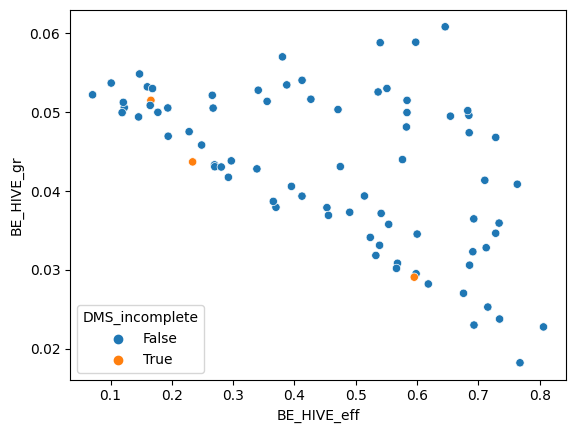

In [26]:
sns.scatterplot(x='BE_HIVE_eff', y='BE_HIVE_gr', hue='DMS_incomplete', data=BE_HIVE_pred_DF)

In [27]:
ABE_BE_HIVE_DF = pd.merge(Pred_ABE_DF[['sgName', 'sgRNA Seq', 'ABE_growthrate']].drop_duplicates(), BE_HIVE_pred_DF, on='sgRNA Seq')

In [28]:
ABE_BE_HIVE_DF

,sgName,sgRNA Seq,ABE_growthrate,BE_HIVE_Prediction,DMS_incomplete,MultiAA,BE_HIVE_eff,BE_HIVE_gr
0,BCRABL_1794,CAGTACGGGGAGGTGTACGA,0.052873,"[[[Y253C, E255G], 0.669483482837677], [[Y253C]...",False,True,0.567942,0.030844
1,BCRABL_1795,AGTACGGGGAGGTGTACGAG,0.053045,"[[[Y253C], 0.6271244287490845], [[Y253C, E255G...",False,True,0.145785,0.049386
2,BCRABL_1812,AGGTCTTCACGGCCACCGTC,0.054934,"[[[V270A], 0.8743341565132141]]",False,False,0.122453,0.050577
3,BCRABL_1813,GACGGTGGCCGTGAAGACCT,0.055067,"[[[T267A], 0.6119691729545593], [[K271E], 0.16...",False,False,0.160050,0.053202
4,BCRABL_1796,TACGGGGAGGTGTACGAGGG,0.052925,"[[[Y253C, E255G], 0.6200466752052307], [[Y253C...",False,True,0.269595,0.043314
...,...,...,...,...,...,...,...,...
75,BCR2_886,CAGGCTGTATTTCTTCCACA,0.055807,"[[[Y264H], 0.6597711443901062], [[Y264H, L266P...",False,True,0.265972,0.052129
76,BCR2_962,CTCCATGGTGTCCTCCTTCA,0.054682,"[[[M278T], 0.9754413962364197]]",False,False,0.597704,0.058855
77,BCR2_1036,CACCTCCCCGTACTGGCCCC,0.052086,"[[[Y253H, V256A], 0.2377890795469284], [[Y253H...",False,True,0.118922,0.049934
78,BCR2_1047,AAGGAGCTGCACCAGGTTAG,0.051564,"[[[V299A, L301P], 0.7195831537246704], [[L301P...",False,True,0.618247,0.028220


In [29]:
#remove 3 sgRNA with incomplete data
ABE_BE_HIVE_DF = ABE_BE_HIVE_DF.loc[ABE_BE_HIVE_DF['DMS_incomplete']==False]

In [30]:
ABE_2SD = 0.0541397227562014

In [31]:
(ABE_BE_HIVE_DF['ABE_growthrate'] < ABE_2SD).value_counts()

False    41
True     36
Name: ABE_growthrate, dtype: int64

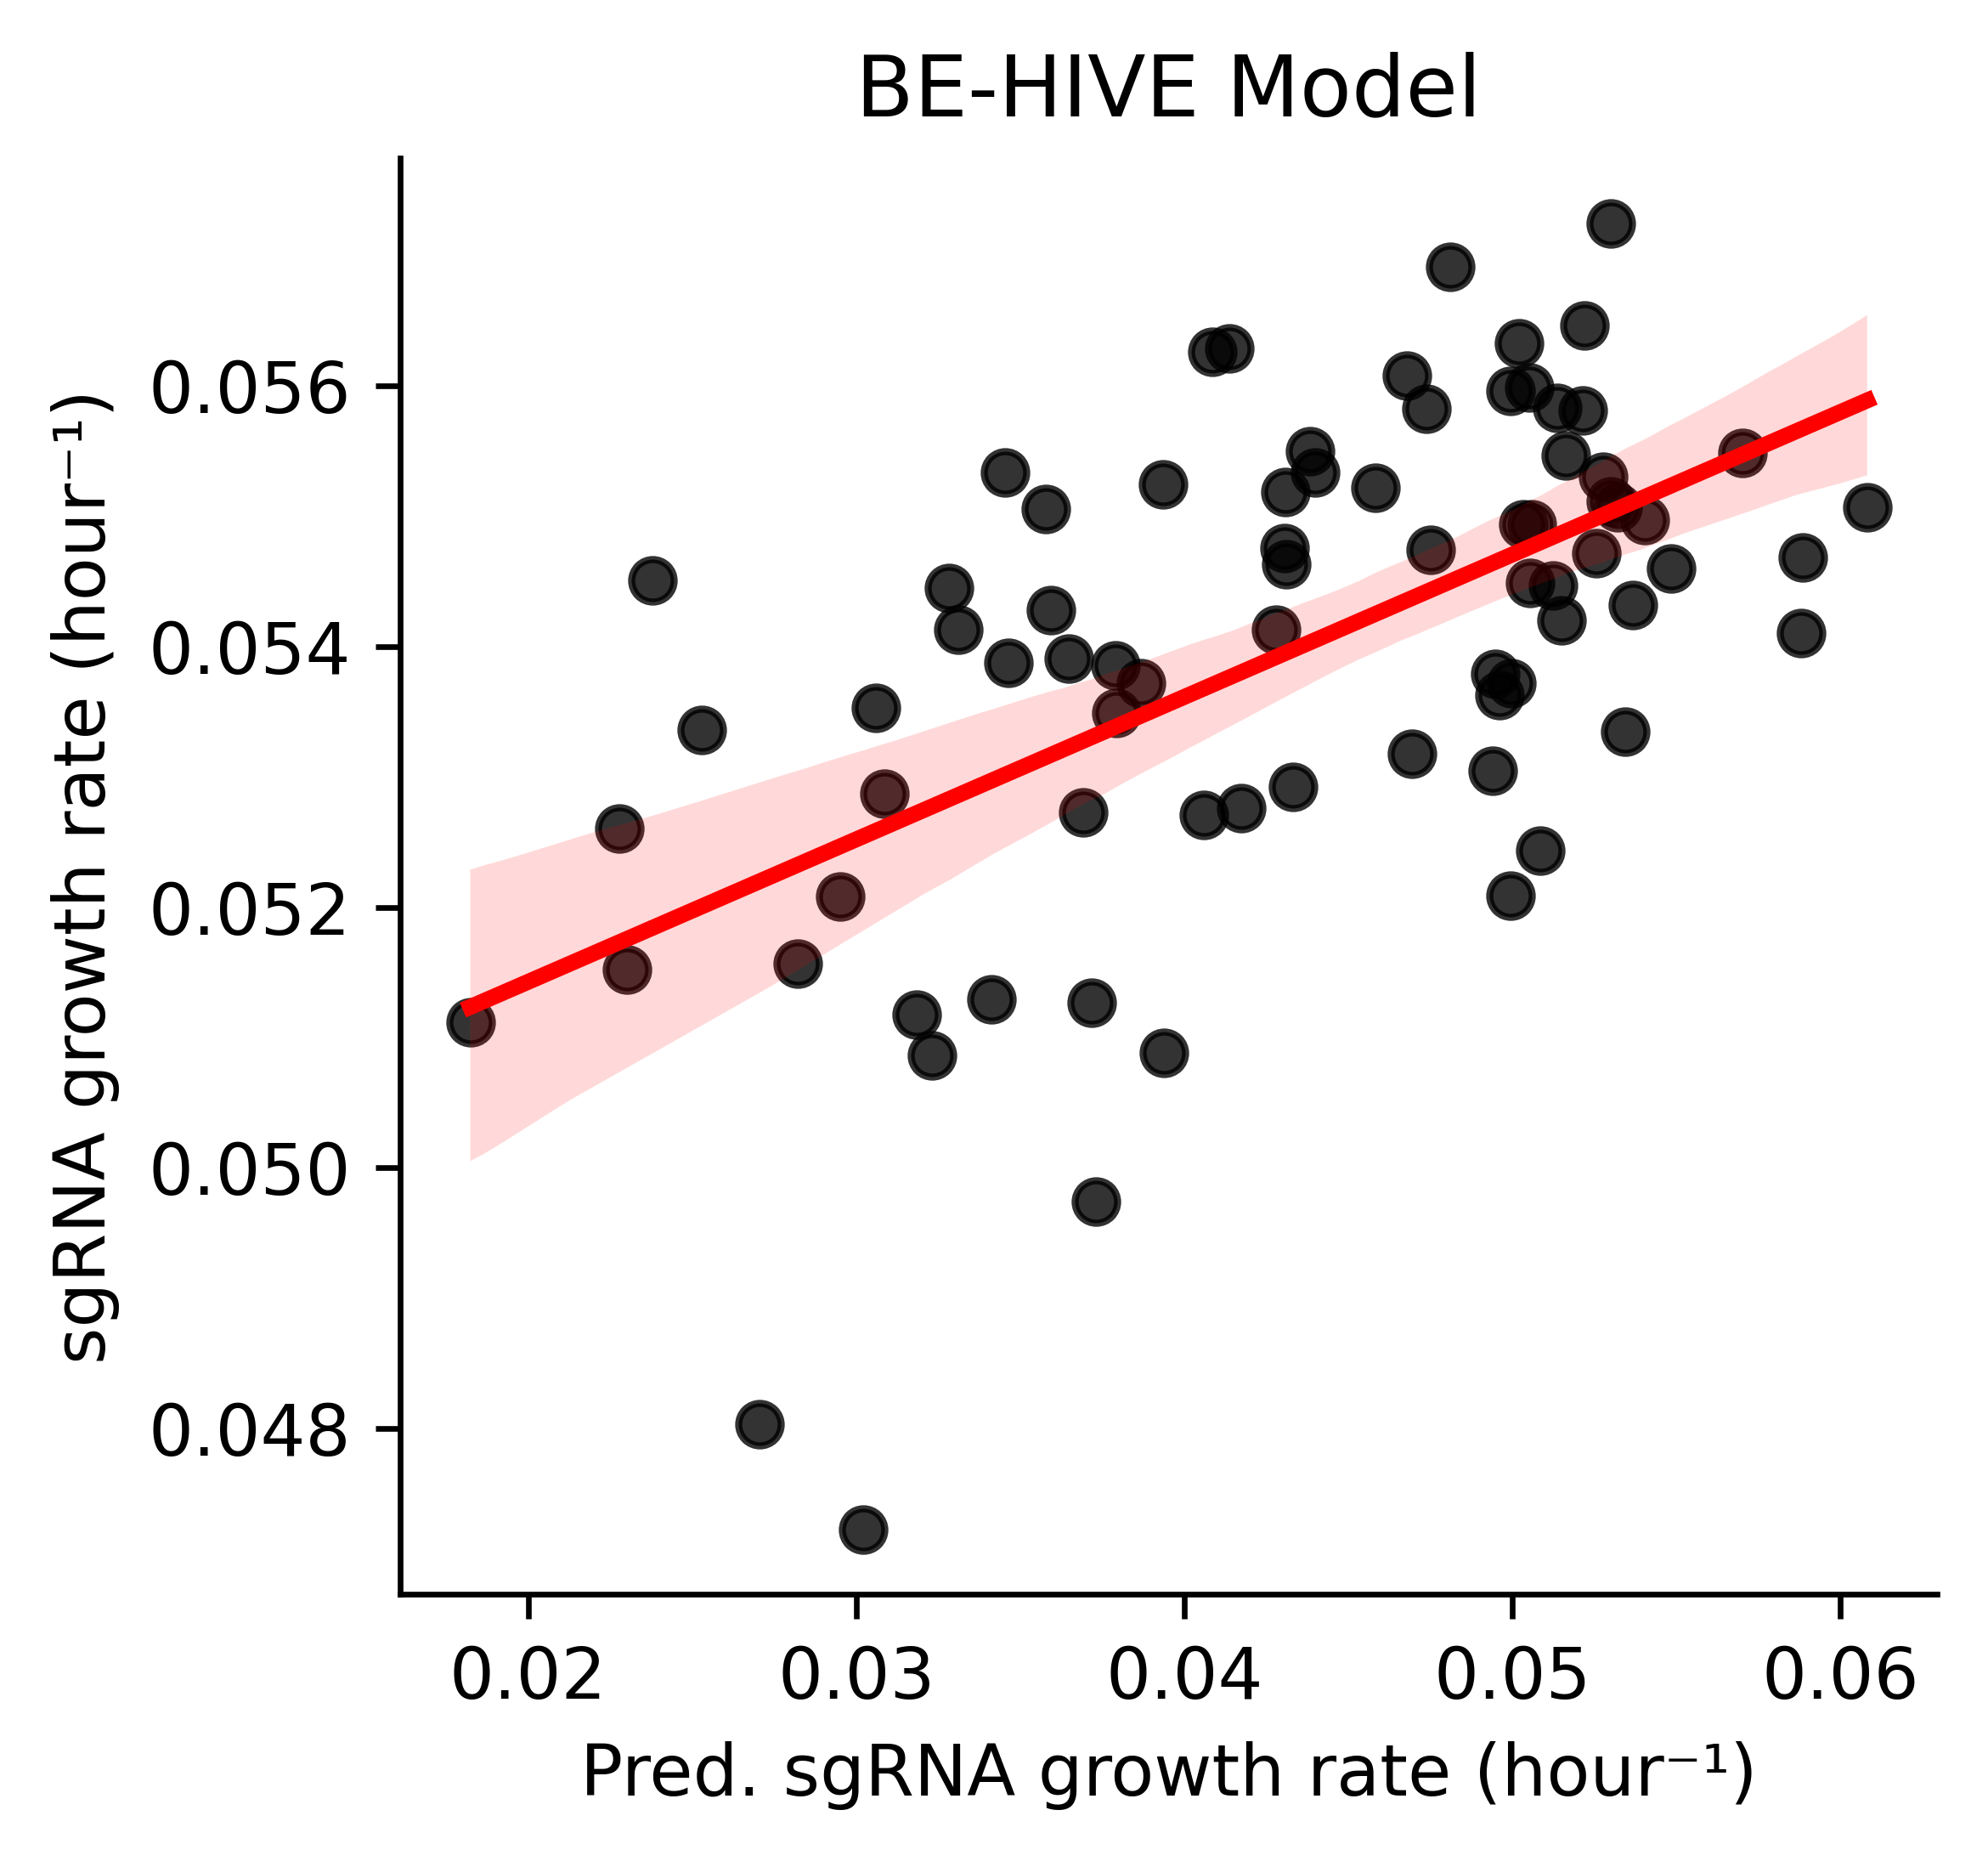

In [32]:
plt.figure(figsize=(4,3.75), dpi=600)
compare = sns.regplot(x='BE_HIVE_gr', y='ABE_growthrate', data=ABE_BE_HIVE_DF, scatter_kws={"color": "black"}, line_kws={"color": "red"})
compare.set(ylabel='sgRNA growth rate (hour⁻¹)', xlabel='Pred. sgRNA growth rate (hour⁻¹)', title = 'BE-HIVE Model')
#plt.vlines(ABE_2SD, ABE_BE_HIVE_DF['ABE_growthrate'].min(), ABE_BE_HIVE_DF['ABE_growthrate'].max(), linestyles="--", color='grey')
#plt.hlines(ABE_2SD, ABE_BE_HIVE_DF['BE_HIVE_gr'].min(), ABE_BE_HIVE_DF['BE_HIVE_gr'].max(), linestyles="--", color='grey')
sns.despine()
plt.tight_layout()
compare.get_figure().savefig("BE_HIVE_model_nuc2to12_0613.svg" , transparent=True) 

In [33]:
pearsonr(ABE_BE_HIVE_DF['BE_HIVE_gr'],ABE_BE_HIVE_DF['ABE_growthrate'])

(0.5670836325200985, 7.572287463433449e-08)

In [34]:
len(ABE_BE_HIVE_DF['sgName'].drop_duplicates())

77

In [35]:
ABE_BE_HIVE_DF[['BE_HIVE_gr', 'ABE_growthrate']].corr()

,BE_HIVE_gr,ABE_growthrate
BE_HIVE_gr,1.000000,0.567084
ABE_growthrate,0.567084,1.000000


In [36]:
ABE_BE_HIVE_DF[['BE_HIVE_gr', 'ABE_growthrate']].corr('spearman')

,BE_HIVE_gr,ABE_growthrate
BE_HIVE_gr,1.000000,0.539934
ABE_growthrate,0.539934,1.000000


In [37]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [39]:
# Note the difference in argument order
Y = ABE_BE_HIVE_DF['ABE_growthrate']
X = ABE_BE_HIVE_DF['BE_HIVE_gr']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

# Print out the statistics
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ABE_growthrate   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     35.55
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           7.57e-08
Time:                        00:03:56   Log-Likelihood:                 388.60
No. Observations:                  77   AIC:                            -773.2
Df Residuals:                      75   BIC:                            -768.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0492      0.001     60.885      0.000       0.048       0.051
BE_HIVE_gr     0.1093      0.018      5.963      0.000       0.073       0.146
==============================================================================
Omnibus:                       10.180   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.184
Skew:                          -0.765   Prob(JB):                      0.00615
Kurtosis:                       3.912   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
results.params

const         0.049242
BE_HIVE_gr    0.109272
dtype: float64

In [41]:
np.sqrt(results.mse_model)

0.009400426589459098

In [42]:
np.sqrt(results.mse_resid)

0.0015765868798233065

In [43]:
root = rmse(ABE_BE_HIVE_DF['ABE_growthrate'], ABE_BE_HIVE_DF['BE_HIVE_gr']*results.params[1] + results.params[0])
root

0.0015559770147466172

In [44]:
results.ssr, results.ess , results.centered_tss

(0.00018642196422232417, 8.83680200638096e-05, 0.0002747899842861338)

In [45]:
results.ess/results.centered_tss

0.32158384627219017

In [46]:
results.ess + results.ssr

0.0002747899842861338

In [47]:
OLS_DF = pd.DataFrame(zip(np.linspace(0,0.06,200),( np.linspace(0,0.06,200) * results.params[1]) + results.params[0]), columns=['BE_HIVE','Pred'])

<AxesSubplot:xlabel='BE_HIVE_gr', ylabel='ABE_growthrate'>

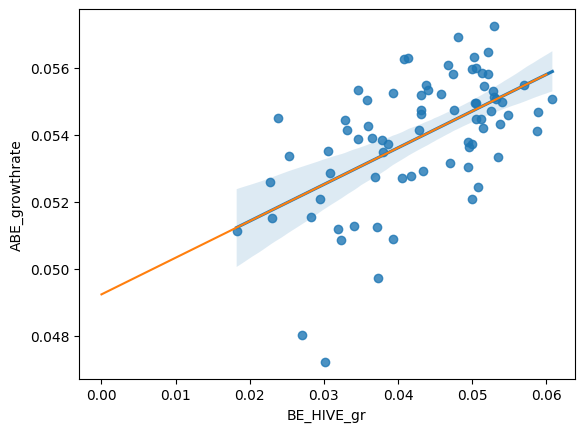

In [48]:
sns.regplot(x='BE_HIVE_gr', y='ABE_growthrate', data=ABE_BE_HIVE_DF)
sns.lineplot(x='BE_HIVE', y='Pred', data=OLS_DF)

## Multi-Edit Predictions

In [49]:
ABE_BE_HIVE_DF.loc[ABE_BE_HIVE_DF['sgName']=='BCRABL_1792', 'BE_HIVE_Prediction']

13    [[[Q252R, Y253C], 0.9174932241439819]]
Name: BE_HIVE_Prediction, dtype: object

In [50]:
ABE_BE_HIVE_DF.loc[ABE_BE_HIVE_DF['sgName']=='BCRABL_1829', 'BE_HIVE_Prediction'].values

array([list([[['T277A', 'M278V'], 0.5781630873680115], [['D276G', 'T277A', 'M278V'], 0.25282400846481323], [['T277A', 'M278V', 'E279G'], 0.05511075630784035]])],
      dtype=object)